In [ ]:
import os
import sys
import requests
from tqdm import tqdm

for ds in [
    'webtext','medium-345M-k40','xl-1542M-k40',
]:
    for split in ['train', 'valid', 'test']:
        filename = ds + "." + split + '.jsonl'
        r = requests.get("https://openaipublic.azureedge.net/gpt-2/output-dataset/v1/" + filename, stream=True)

        with open(os.path.join("/content/drive/MyDrive/data", filename), 'wb') as f:
            file_size = int(r.headers["content-length"])
            chunk_size = 1000
            with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
                # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
                for chunk in r.iter_content(chunk_size=chunk_size):
                    f.write(chunk)
                    pbar.update(chunk_size)

Fetching webtext.train.jsonl: 679Mit [00:16, 42.4Mit/s]                                             
Fetching webtext.valid.jsonl: 13.6Mit [00:00, 41.5Mit/s]                                            
Fetching webtext.test.jsonl: 13.5Mit [00:00, 41.3Mit/s]                                             
Fetching medium-345M-k40.train.jsonl: 784Mit [00:22, 34.9Mit/s]                                     
Fetching medium-345M-k40.valid.jsonl: 15.7Mit [00:00, 43.9Mit/s]                                    
Fetching medium-345M-k40.test.jsonl: 15.6Mit [00:00, 43.3Mit/s]                                     
Fetching xl-1542M-k40.train.jsonl: 748Mit [00:20, 36.5Mit/s]                                        
Fetching xl-1542M-k40.valid.jsonl: 15.0Mit [00:00, 38.0Mit/s]                                       
Fetching xl-1542M-k40.test.jsonl: 14.6Mit [00:00, 38.6Mit/s]                                        


In [1]:
!pip install transformers

In [2]:
import spacy
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize, word_tokenize
import nltk
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import xgboost as xgb
from scipy.stats import zscore


nlp = spacy.load('en_core_web_sm')

In [ ]:
import pandas as pd
Human_df_train = pd.read_json(path_or_buf="/content/drive/MyDrive/data/webtext.train.jsonl", lines=True)
GPT_df_train = pd.read_json(path_or_buf="/content/drive/MyDrive/data/medium-345M-k40.train.jsonl", lines=True)

Human_df_test = pd.read_json(path_or_buf="/content/drive/MyDrive/data/webtext.test.jsonl", lines=True)
GPT_df_test = pd.read_json(path_or_buf="/content/drive/MyDrive/data/medium-345M-k40.test.jsonl", lines=True)

Human_df_val = pd.read_json(path_or_buf="/content/drive/MyDrive/data/webtext.valid.jsonl", lines=True)
GPT_df_val = pd.read_json(path_or_buf="/content/drive/MyDrive/data/medium-345M-k40.valid.jsonl", lines=True)

In [ ]:
def add_label_column(df, label):
    df['label'] = label
    return df

# Preprocess datasets
GPT_df_train = add_label_column(GPT_df_train, 1)
GPT_df_test = add_label_column(GPT_df_test, 1)
GPT_df_val = add_label_column(GPT_df_val, 1)

Human_df_train = add_label_column(Human_df_train, 0)
Human_df_test = add_label_column(Human_df_test, 0)
Human_df_val = add_label_column(Human_df_val, 0)

In [ ]:
def remove_short_texts(df, lenght):
  return df[df['length'] >= lenght]

In [ ]:
# Add source columns
Human_df_train['source'] = 'Human_train'
GPT_df_train['source'] = 'GPT_train'

Human_df_train = remove_short_texts(Human_df_train, 10).sample(25000,random_state=42)
GPT_df_train = remove_short_texts(GPT_df_train, 10).sample(25000,random_state=42)


Human_df_test['source'] = 'Human_test'
GPT_df_test['source'] = 'GPT_test'



Human_df_val['source'] = 'Human_val'
GPT_df_val['source'] = 'GPT_val'

# Concatenate all the datasets
GPT_df = pd.concat([GPT_df_train, GPT_df_test, GPT_df_val], ignore_index=True)
Human_df = pd.concat([Human_df_train, Human_df_test, Human_df_val], ignore_index=True)

In [ ]:
GPT_df = GPT_df.drop(['id', 'length', 'ended'], axis=1)
Human_df = Human_df.drop(['id', 'length', 'ended'], axis=1)

In [ ]:
import re
from tqdm import tqdm
tqdm.pandas()

class TextPreprocessor:
    def __init__(self):
        # Compile regex patterns for performance
        self.space_before_punct = re.compile(r'\s+([.,?!;:])')
        self.space_after_punct = re.compile(r'([.,?!;:])\s+')
        self.contractions = re.compile(r"(\w) n\'t")
        self.double_dashes = re.compile(r"\s*--\s*")
        self.hyphens = re.compile(r"\s+-\s+")
        self.single_quotes_start = re.compile(r"(\w)'(\s)")
        self.single_quotes_end = re.compile(r"(\s)'(\w)")
        self.mentions = re.compile(r'(@.*?)[\s]')
        self.links = re.compile(r'https?:\/\/[^\s\n\r]+')
        self.embedded_quotes = re.compile(r'"\s([^"]+)\s"')
        self.single_quotes_embedded = re.compile(r"'\s([^']+)\s'")
        self.space_after_open_parenthesis = re.compile(r'\(\s')
        self.space_before_close_parenthesis = re.compile(r'\s\)')
        self.multi_spaces = re.compile(r'\s+')
        self.special_chars = re.compile(r'\r+|\n+|\t+')

    def remove_unicode(self,text):
      return ''.join(char for char in text if ord(char) < 128)


    def preprocess(self, text):
        text = self.space_before_punct.sub(r'\1', text)
        text = self.space_after_punct.sub(r'\1 ', text)
        text = text.replace("\\'", "'")
        text = text.replace("\n", " ").replace("\\", "").replace('*', '')
        text = self.remove_unicode(text)
        text = self.contractions.sub(r"\1n't", text)
        text = self.double_dashes.sub("--", text)
        text = self.hyphens.sub("-", text)
        text = self.single_quotes_start.sub(r"\1'", text)
        text = self.single_quotes_end.sub(r" '\1", text)
        text = self.mentions.sub(' ', text)
        text = self.links.sub(' ', text)
        text = text.replace('#', ' ').replace("&amp;", "&")
        text = self.embedded_quotes.sub(r'"\1"', text)
        text = self.single_quotes_embedded.sub(r"\1", text)
        text = self.space_after_open_parenthesis.sub('(', text)
        text = self.space_before_close_parenthesis.sub(')', text)
        text = self.multi_spaces.sub(' ', text)
        return text

preprocessor = TextPreprocessor()
GPT_df.text = GPT_df.text.progress_map(preprocessor.preprocess)
Human_df.text = Human_df.text.progress_map(preprocessor.preprocess)

100%|██████████| 35000/35000 [00:39<00:00, 891.17it/s]


In [ ]:
def process_text(df):
    pos_list, dep_list = [], []
    total_words = 0
    all_ratios = []

    pos_tags = ['NOUN', 'PUNCT', 'VERB', 'ADP', 'DET', 'PRON', 'ADJ', 'AUX', 'ADV', 'CCONJ', 'PROPN', 'PART', 'SCONJ', 'NUM', 'SPACE', 'SYM', 'X', 'INTJ']
    dep_tags = ['punct', 'det', 'prep', 'pobj', 'nsubj', 'amod', 'dobj', 'aux', 'advmod', 'ROOT', 'conj', 'cc', 'compound', 'advcl', 'mark', 'ccomp', 'xcomp', 'relcl', 'acomp', 'attr', 'auxpass', 'poss', 'nsubjpass', 'neg', 'pcomp', 'nummod', 'acl', 'appos', 'prt', 'npadvmod']

    for doc in tqdm(nlp.pipe(df['text'].values, batch_size=2000)):
        pos_list.extend([token.pos_ for token in doc])
        dep_list.extend([token.dep_ for token in doc])

        pos_counts = defaultdict(int, {pos_tag: 0 for pos_tag in pos_tags})
        dep_counts = defaultdict(int, {dep_tag: 0 for dep_tag in dep_tags})

        for token in doc:
            pos_counts[token.pos_] += 1
            dep_counts[token.dep_] += 1

        total_tokens = len(doc)
        pos_ratios = {f'pos_{pos}': count/total_tokens for pos, count in pos_counts.items()}
        dep_ratios = {f'dep_{dep}': count/total_tokens for dep, count in dep_counts.items()}
        all_ratios.append({**pos_ratios, **dep_ratios})

        total_words += len(doc)

    pos_counts = Counter(pos_list)
    normalized_pos_counts = {k: v / total_words for k, v in pos_counts.items()}

    dep_counts = Counter(dep_list)
    normalized_dep_counts = {k: v / total_words for k, v in dep_counts.items()}

    return normalized_pos_counts, normalized_dep_counts, all_ratios

# Get results for GPT_df
pos_counts_GPT, dep_counts_GPT, ratios_GPT = process_text(GPT_df)
ratios_df_GPT = pd.DataFrame(ratios_GPT)
GPT_df = pd.concat([GPT_df, ratios_df_GPT], axis=1)

# Get results for Human_df
pos_counts_Human, dep_counts_Human, ratios_Human = process_text(Human_df)
ratios_df_Human = pd.DataFrame(ratios_Human)
Human_df = pd.concat([Human_df, ratios_df_Human], axis=1)

35000it [45:51, 12.72it/s]
35000it [38:21, 15.20it/s]


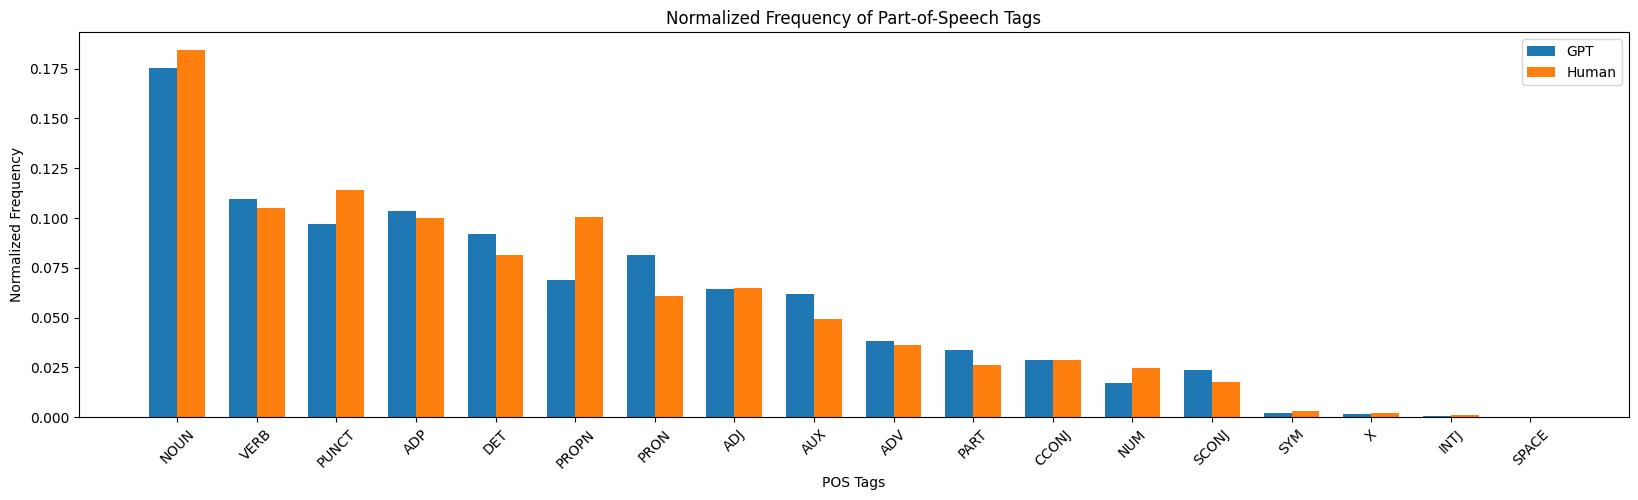

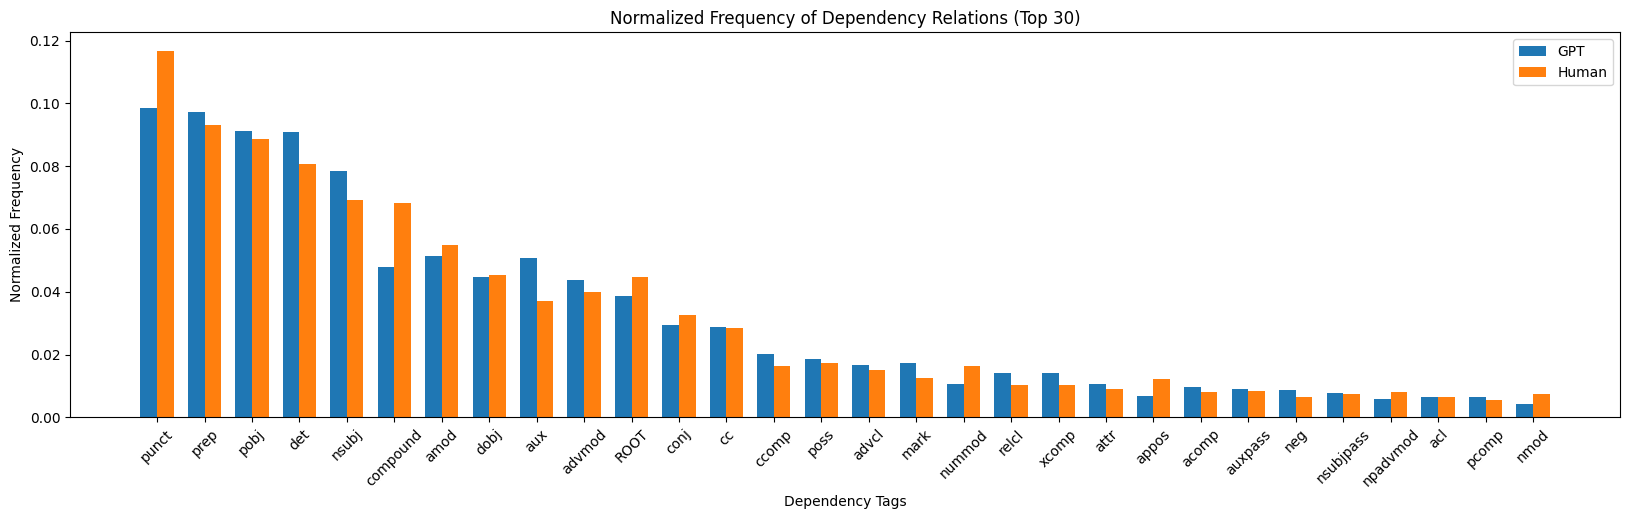

In [ ]:
def plot_data(labels, gpt_vals, human_vals, xlabel, title):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.bar(x - width/2, gpt_vals, width, label='GPT')
    ax.bar(x + width/2, human_vals, width, label='Human')
    ax.set_ylabel('Normalized Frequency')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    plt.show()

# Using the results from our earlier optimized function for plotting

# For POS tags
ud_tags = ['NOUN', 'PUNCT', 'VERB', 'ADP', 'DET', 'PRON', 'ADJ', 'AUX', 'ADV', 'CCONJ', 'PROPN', 'PART', 'SCONJ', 'NUM', 'SPACE', 'SYM', 'X', 'INTJ']
common_keys = set(pos_counts_GPT.keys()).union(set(pos_counts_Human.keys())).intersection(set(ud_tags))

labels = list(common_keys)
gpt_vals = [pos_counts_GPT.get(key, 0) for key in common_keys]
human_vals = [pos_counts_Human.get(key, 0) for key in common_keys]

# Combined frequencies for sorting
combined_vals = [a+b for a, b in zip(gpt_vals, human_vals)]
combined, labels, gpt_vals, human_vals = zip(*sorted(zip(combined_vals, labels, gpt_vals, human_vals), reverse=True))

plot_data(labels, gpt_vals, human_vals, 'POS Tags', 'Normalized Frequency of Part-of-Speech Tags')

# For Dependency tags
combined_counts = Counter(dep_counts_GPT) + Counter(dep_counts_Human)
common_keys, _ = zip(*combined_counts.most_common(30))

gpt_vals = [dep_counts_GPT.get(key, 0) for key in common_keys]
human_vals = [dep_counts_Human.get(key, 0) for key in common_keys]

plot_data(common_keys, gpt_vals, human_vals, 'Dependency Tags', 'Normalized Frequency of Dependency Relations (Top 30)')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
torch.cuda.empty_cache()

In [ ]:

# Perplexity calculation functions
model = GPT2LMHeadModel.from_pretrained('gpt2').eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def batch_perplexity(sentences):
    tokenize_input = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    tokenize_input = {k: v.to(device) for k, v in tokenize_input.items()}
    loss = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        outputs = model(**tokenize_input, labels=tokenize_input["input_ids"])
        total_loss = loss(outputs.logits.view(-1, outputs.logits.size(-1)), tokenize_input["input_ids"].view(-1))
    return torch.exp(total_loss).item()

def avg_std_var_perplexity(text, batch_size=20000):
    sentences = sent_tokenize(text)
    data_loader = DataLoader(sentences, batch_size=batch_size)
    perp_values = [batch_perplexity(list(batch)) for batch in data_loader]
    return np.mean(perp_values), np.std(perp_values), np.var(perp_values)

# Apply average, standard deviation, and variance perplexity on answer column
for dataframe in [GPT_df, Human_df]:
    results = []
    # Add progress bar for dataframe processing
    for text in tqdm(dataframe['text'], desc="Processing DataFrames"):
        results.append(avg_std_var_perplexity(text))
    dataframe['avg_perplexity'], dataframe['std_perplexity'], dataframe['var_perplexity'] = zip(*results)


In [ ]:
# Function to calculate lexical diversity
def lexical_diversity(text):
    words = word_tokenize(text)
    unique_words = set(words)
    return len(unique_words) / len(words) if len(words) > 0 else 0


# Function to calculate average sentence length
def avg_and_std_sentence_length(text):
    sentences = sent_tokenize(text)
    lengths = [len(s.split()) for s in sentences]
    return np.mean(lengths), np.std(lengths)


def fano_factor(text):
    word_list = text.split()
    frequency = [word_list.count(w) for w in word_list]
    mean_freq = np.mean(frequency)
    var_freq = np.var(frequency)
    if mean_freq != 0:
        fano_val = var_freq / mean_freq
    else:
        fano_val = 0
    return fano_val


def sentence_complexity(text):
    clause_markers = ['and', 'or', 'but', 'because', 'if', 'while', 'although', 'though', 'unless', 'since', 'once']
    sentences = sent_tokenize(text)
    total_clauses = 0

    for sentence in sentences:
        tokenized_sentence = word_tokenize(sentence)
        # We add 1 to account for the main clause in every sentence
        total_clauses += sum(1 for word in tokenized_sentence if word in clause_markers) + 1

    return total_clauses / len(sentences) if sentences else 0

# Calculate word document frequency
all_text = pd.concat([GPT_df['text'], Human_df['text']])
all_documents = all_text.apply(lambda x: set(x.split())).tolist()
all_words = [word for document in all_documents for word in document]
word_document_frequency = Counter(all_words)
total_documents = len(all_documents)

# Apply the functions on answer column
for df in [GPT_df, Human_df]:
    df['lexical_diversity'] = df['text'].apply(lexical_diversity)
    df['fano_factor'] = df['text'].apply(lambda x:fano_factor(x))

GPT_df['avg_sentence_length'], GPT_df['std_sentence_length'] = zip(*GPT_df['text'].apply(avg_and_std_sentence_length))
Human_df['avg_sentence_length'], Human_df['std_sentence_length'] = zip(*Human_df['text'].apply(avg_and_std_sentence_length))
GPT_df['sentence_complexity'] = GPT_df['text'].apply(sentence_complexity)
Human_df['sentence_complexity'] = Human_df['text'].apply(sentence_complexity)

In [ ]:
GPT_df.to_hdf("/content/drive/MyDrive/GPT_df.h5",key='GPT_df', mode='w')
Human_df.to_hdf("/content/drive/MyDrive/Human_df.h5",key='Human_df', mode='w')

In [4]:
import pandas as pd
GPT_df = pd.read_hdf("/content/drive/MyDrive/GPT2/GPT_df_gpt2.h5")
Human_df = pd.read_hdf("/content/drive/MyDrive/GPT2/Human_df_gpt2.h5")

In [5]:
GPT_df = GPT_df.fillna(0)
Human_df = Human_df.fillna(0)

In [16]:
df_1 = Human_df.copy().drop(['label', 'text','source'], axis=1)
df_2 = GPT_df.copy().drop(['label', 'text','source'], axis=1)

In [6]:
# Remove outliers based on z-score
from scipy import stats
import numpy as np
def remove_outliers(df, column_names, threshold=3):
    return df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

columns = GPT_df.drop(['label', 'text','source'], axis=1).columns
GPT_df_without_outliers = remove_outliers(GPT_df.dropna().drop(['label', 'text','source'], axis=1), columns)
Human_df_without_outliers = remove_outliers(Human_df.dropna().drop(['label', 'text','source'], axis=1), columns)

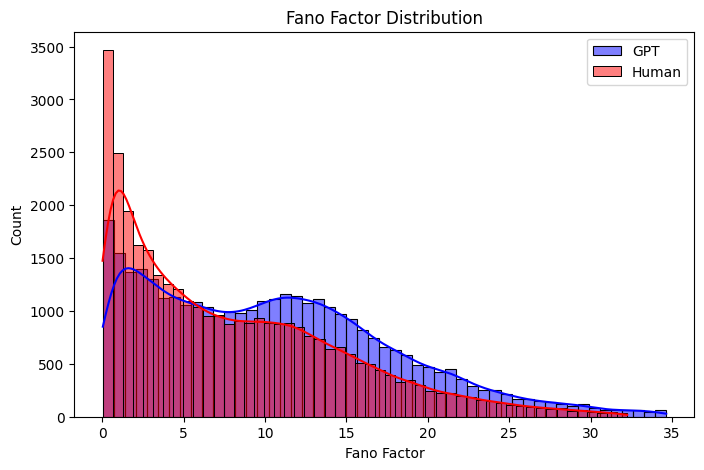

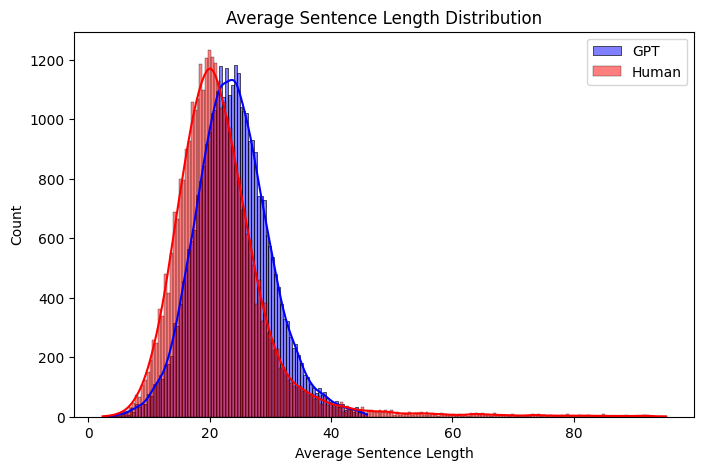

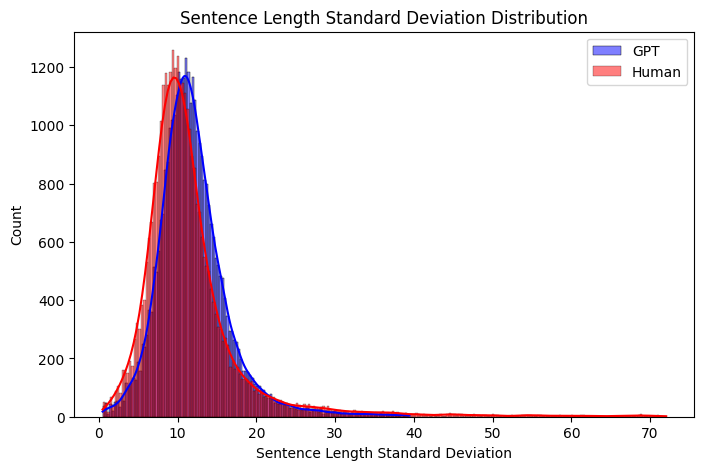

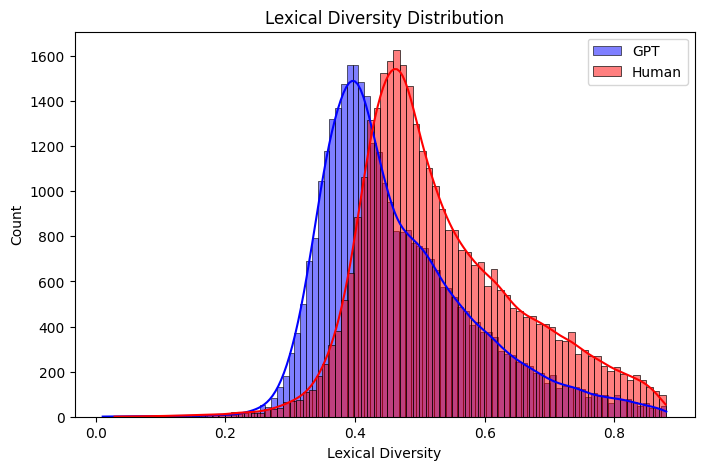

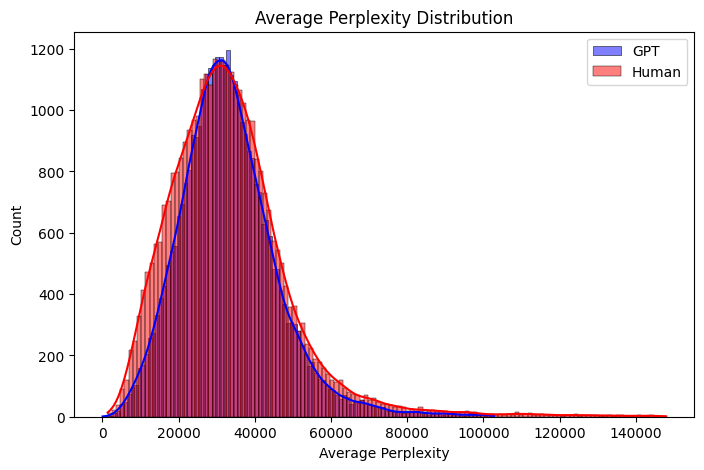

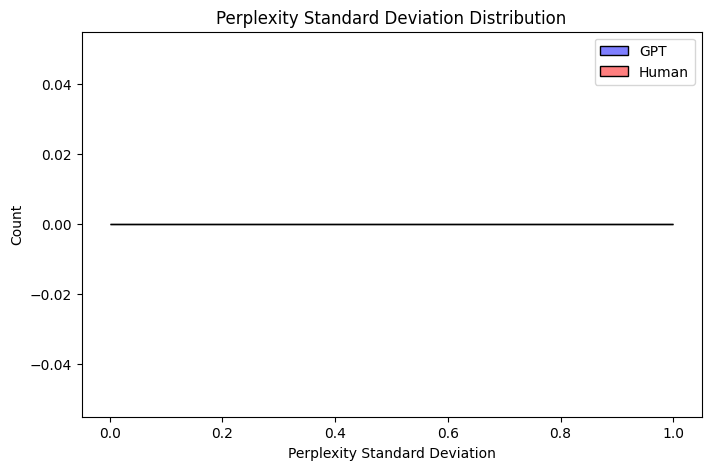

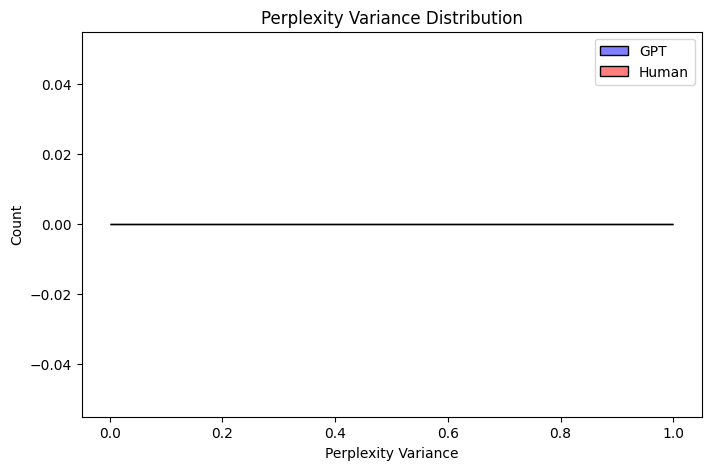

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of features
def plot_distribution(df1, df2, column, title, xlabel):
    plt.figure(figsize=(8, 5))
    sns.histplot(df1[column], color='blue', kde=True, label='GPT')
    sns.histplot(df2[column], color='red', kde=True, label='Human')
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

features_to_plot = [
    ('fano_factor', 'Fano Factor Distribution', 'Fano Factor'),
    ('avg_sentence_length', 'Average Sentence Length Distribution', 'Average Sentence Length'),
    ('std_sentence_length', 'Sentence Length Standard Deviation Distribution', 'Sentence Length Standard Deviation'),
    ('lexical_diversity', 'Lexical Diversity Distribution', 'Lexical Diversity'),
    ('avg_perplexity', 'Average Perplexity Distribution', 'Average Perplexity'),
    ('std_perplexity', 'Perplexity Standard Deviation Distribution', 'Perplexity Standard Deviation'),
    ('var_perplexity', 'Perplexity Variance Distribution', 'Perplexity Variance')
]

for feature, title, xlabel in features_to_plot:
    plot_distribution(GPT_df_without_outliers, Human_df_without_outliers, feature, title, xlabel)

[0]	validation_0-error:0.25630	validation_1-error:0.27020
[1]	validation_0-error:0.24082	validation_1-error:0.25550
[2]	validation_0-error:0.22706	validation_1-error:0.24630
[3]	validation_0-error:0.22002	validation_1-error:0.24040
[4]	validation_0-error:0.21196	validation_1-error:0.23360
[5]	validation_0-error:0.20732	validation_1-error:0.23060
[6]	validation_0-error:0.20244	validation_1-error:0.22670
[7]	validation_0-error:0.19748	validation_1-error:0.22050
[8]	validation_0-error:0.19222	validation_1-error:0.22030
[9]	validation_0-error:0.18778	validation_1-error:0.21680
[10]	validation_0-error:0.18422	validation_1-error:0.21410
[11]	validation_0-error:0.18134	validation_1-error:0.21080
[12]	validation_0-error:0.17766	validation_1-error:0.20950
[13]	validation_0-error:0.17490	validation_1-error:0.20840
[14]	validation_0-error:0.17302	validation_1-error:0.20730
[15]	validation_0-error:0.16982	validation_1-error:0.20740
[16]	validation_0-error:0.16748	validation_1-error:0.20520
[17]	va

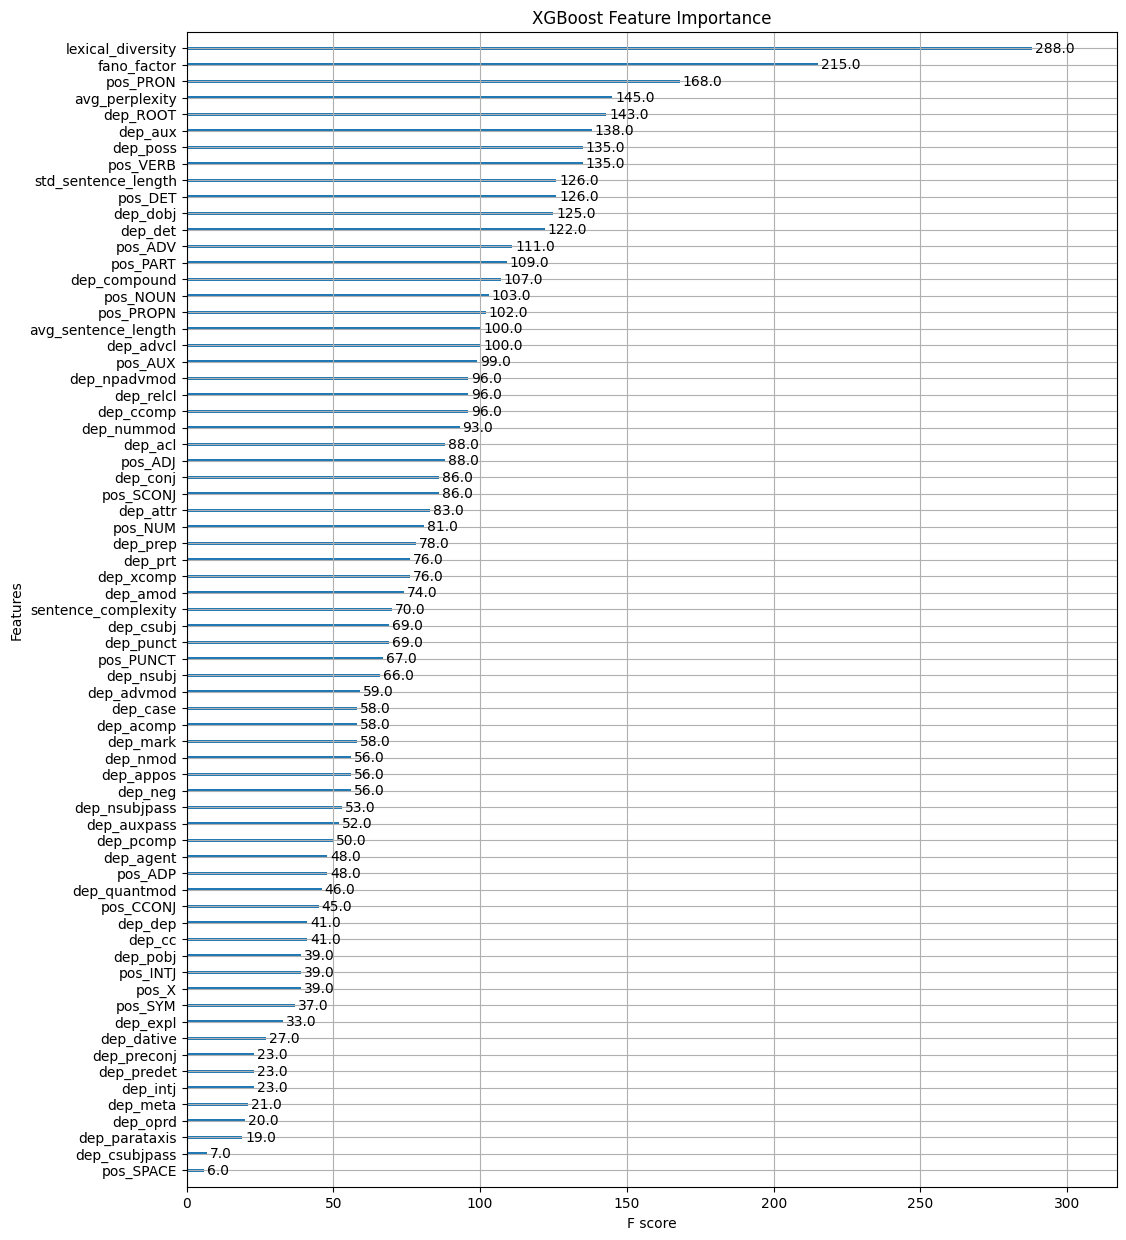

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Concatenate the two dataframes for ease of operation
combined_df = pd.concat([Human_df, GPT_df])

# Create datasets based on the 'source' column
X_train = combined_df[combined_df['source'].isin(['Human_train', 'GPT_train'])].drop(['source','text'], axis=1)
y_train = X_train.pop('label')

X_test = combined_df[combined_df['source'].isin(['Human_test', 'GPT_test'])].drop(['source','text'], axis=1)
y_test = X_test.pop('label')


X_val = combined_df[combined_df['source'].isin(['Human_val', 'GPT_val'])].drop(['source','text'], axis=1)
y_val = X_val.pop('label')

clf = xgb.XGBClassifier(eval_metric="error", early_stopping_rounds=15)
evals = [(X_train, y_train), (X_val, y_val)]
clf.fit(X_train, y_train, eval_set=evals, verbose=True)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12, 15))
xgb.plot_importance(clf, ax=ax, importance_type='weight', title="XGBoost Feature Importance")
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()